# Judge Hiciano Jupyter Notebook

In [1]:
# Imports required for project
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn as sk

# Plotting
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D

from pprint import pprint

# sklearn Metrics and tunning
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import KFold, cross_val_score, train_test_split

#import machine learning related libraries
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb



/Users/jhiciano/.pyenv/versions/3.6.7/envs/cs-test/lib/python3.6/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/Users/jhiciano/.pyenv/versions/3.6.7/envs/cs-test/lib/python3.6/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
pd.options.display.max_rows = 50000
pd.set_option('display.max_columns', None)  
pd.set_option('display.max_colwidth', -1)

## Description of variables
• sessionID: Session ID. 1-50000 in train.csv, 50001-55111 in test.csv.

• hour: Hour when the session was started. Numbers between 0 and 23.

• weekday: Day of the week when the session was started. 5: Friday, 6: Saturday, 7: Sunday, 1: Monday.

• duration: Time in seconds passed since the start of the session.

• clickCount: Number of products that were visited (clicked).

• clickMin: Lowest price of the products visited (clicked).

• clickMax: Highest price of the products visited (clicked).

• clickTotal: Sum of the prices of all the products visited (clicked).

• cartCount: Number of products that were added to the cart.

• cartMin: Lowest price of the products in the cart.

• cartMax: Highest price of the products in the cart.

• cartTotal: Sum of the prices of all the products in the cart.

• cartStep: Purchase processing step. Possible values: 1,2,3,4,5.

• status: Whether the customer is online. ‘y’: yes. ‘n’: no.

• availability: Whether the cart is orderable or not. There are seven possible values.

• customerID: customer ID. 1-25038 in train.csv. In test.csv there exist both old and new customers.

• purchase: Highest purchase price in history for the customer.

• score: Customer score evaluated by the online store.

• account: Lifetime of the customer’s account in months.

• payments: Number of payments made by the customer.

• age: Age of the customer.

• salutation: Salutation of the customer. 1: Mr, 2: Ms, 3: Company.

• lastOrder: Time in days passed since the last order.

• order: (Response variable) Whether the order is placed. ‘y’: yes. ‘n’: no.


In [238]:
df_train = pd.read_csv("../data/train.csv") 
df_test = pd.read_csv("../data/test.csv")

In [239]:
drop_columns_train = ['order','sessionID','hour','weekday','duration','availability']
drop_columns_submission = ['sessionID','hour','weekday','availability','duration']

In [240]:
df_test.head()

,sessionID,hour,weekday,duration,clickCount,clickMin,clickMax,clickTotal,cartCount,cartMin,cartMax,cartTotal,cartStep,status,availability,customerID,purchase,score,account,payments,age,salutation,lastOrder
0,50001,18,7,136.833,3,39.99,39.99,79.98,1,39.99,39.99,39.99,2.0,y,completely orderable,25039.0,1300.0,489.0,188.0,5.0,49.0,1.0,65.0
1,50001,18,7,189.984,3,39.99,39.99,79.98,1,39.99,39.99,39.99,NaN,y,completely orderable,25039.0,1300.0,489.0,188.0,5.0,49.0,1.0,65.0
2,50001,18,7,342.894,6,16.99,39.99,113.96,2,16.99,39.99,56.98,NaN,NaN,NaN,25039.0,1300.0,489.0,188.0,5.0,49.0,1.0,65.0
3,50001,18,7,411.051,8,16.99,39.99,149.94,3,16.99,39.99,74.97,NaN,NaN,NaN,25039.0,1300.0,489.0,188.0,5.0,49.0,1.0,65.0
4,50001,18,7,460.049,10,16.99,39.99,189.92,4,16.99,39.99,94.96,NaN,NaN,NaN,25039.0,1300.0,489.0,188.0,5.0,49.0,1.0,65.0


In [241]:
df_test['sess_count'] = df_test.groupby('sessionID')['sessionID'].transform('count')
df_test = df_test.drop(drop_columns_submission,axis=1)
df_test = pd.get_dummies(df_test)
df_test =pd.DataFrame(df_test).fillna(0)
df_test_cl = df_test

In [242]:
df_test_cl.head()

,clickCount,clickMin,clickMax,clickTotal,cartCount,cartMin,cartMax,cartTotal,cartStep,customerID,purchase,score,account,payments,age,salutation,lastOrder,sess_count,status_n,status_y
0,3,39.99,39.99,79.98,1,39.99,39.99,39.99,2.0,25039.0,1300.0,489.0,188.0,5.0,49.0,1.0,65.0,9,0,1
1,3,39.99,39.99,79.98,1,39.99,39.99,39.99,0.0,25039.0,1300.0,489.0,188.0,5.0,49.0,1.0,65.0,9,0,1
2,6,16.99,39.99,113.96,2,16.99,39.99,56.98,0.0,25039.0,1300.0,489.0,188.0,5.0,49.0,1.0,65.0,9,0,0
3,8,16.99,39.99,149.94,3,16.99,39.99,74.97,0.0,25039.0,1300.0,489.0,188.0,5.0,49.0,1.0,65.0,9,0,0
4,10,16.99,39.99,189.92,4,16.99,39.99,94.96,0.0,25039.0,1300.0,489.0,188.0,5.0,49.0,1.0,65.0,9,0,0


## Feature Enigneering on Training Data

Currently droping 'order', 'sessionID', and 'age' 

In [207]:
df_train['sess_count'] = df_train.groupby('sessionID')['sessionID'].transform('count')
df_train['ordered'] = (df_train['order'] !='n').astype(int) #Converts string `order` to int value for training

df_train_clensed = df_train.drop(drop_columns_train,axis=1)
df_train_clensed = pd.get_dummies(df_train_clensed)
df_train_clensed =pd.DataFrame(df_train_clensed).fillna(0)
df_train_clensed.head()


,clickCount,clickMin,clickMax,clickTotal,cartCount,cartMin,cartMax,cartTotal,cartStep,customerID,purchase,score,account,payments,age,salutation,lastOrder,ordered,sess_count,status_n,status_y
0,1,59.99,59.99,59.99,1,59.99,59.99,59.99,0.0,1.0,600.0,70.0,21.0,1.0,43.0,1.0,49.0,1,3,0,0
1,1,59.99,59.99,59.99,1,59.99,59.99,59.99,2.0,1.0,600.0,70.0,21.0,1.0,43.0,1.0,49.0,1,3,0,1
2,1,59.99,59.99,59.99,1,59.99,59.99,59.99,0.0,1.0,600.0,70.0,21.0,1.0,43.0,1.0,49.0,1,3,0,1
3,0,0.00,0.00,0.00,0,0.00,0.00,0.00,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,5,0,1
4,0,0.00,0.00,0.00,0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,5,0,1


In [200]:
df_train_clensed.describe()

,clickCount,clickMin,clickMax,clickTotal,cartCount,cartMin,cartMax,cartTotal,cartStep,customerID,purchase,score,account,payments,age,salutation,lastOrder,ordered,sess_count,status_n,status_y
count,429013.000000,429013.000000,429013.000000,429013.000000,429013.000000,429013.000000,429013.000000,429013.000000,429013.000000,429013.000000,429013.000000,429013.000000,429013.000000,429013.000000,429013.000000,429013.000000,429013.000000,429013.000000,429013.000000,429013.000000,429013.000000
mean,24.140317,54.932787,145.717758,1181.583473,4.135168,66.816699,106.219546,210.710705,1.270022,7892.890763,1595.353288,311.388140,86.979399,9.858244,29.067923,1.123647,51.748910,0.676040,16.748185,0.007014,0.619154
std,30.398164,148.465331,282.547541,3361.639890,4.451778,174.092255,211.961823,457.222953,1.498258,8268.650781,2710.189590,255.283358,109.222633,29.009391,23.515421,0.902273,98.779129,0.467985,14.919752,0.083454,0.485595
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,5.000000,6.990000,24.990000,134.790000,1.000000,8.990000,19.990000,39.980000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,0.000000,0.000000
50%,13.000000,11.990000,49.990000,382.520000,3.000000,14.990000,39.900000,85.910000,1.000000,5336.000000,600.000000,473.000000,37.000000,3.000000,35.000000,1.000000,13.000000,1.000000,13.000000,0.000000,1.000000
75%,31.000000,29.990000,99.990000,1038.040000,5.000000,34.990000,74.990000,201.930000,2.000000,14998.000000,2500.000000,535.000000,156.000000,11.000000,48.000000,2.000000,51.000000,1.000000,21.000000,0.000000,1.000000
max,200.000000,5999.990000,6999.990000,115742.000000,108.000000,6999.990000,6999.990000,23116.880000,5.000000,25038.000000,50000.000000,638.000000,600.000000,868.000000,99.000000,3.000000,738.000000,1.000000,257.000000,1.000000,1.000000


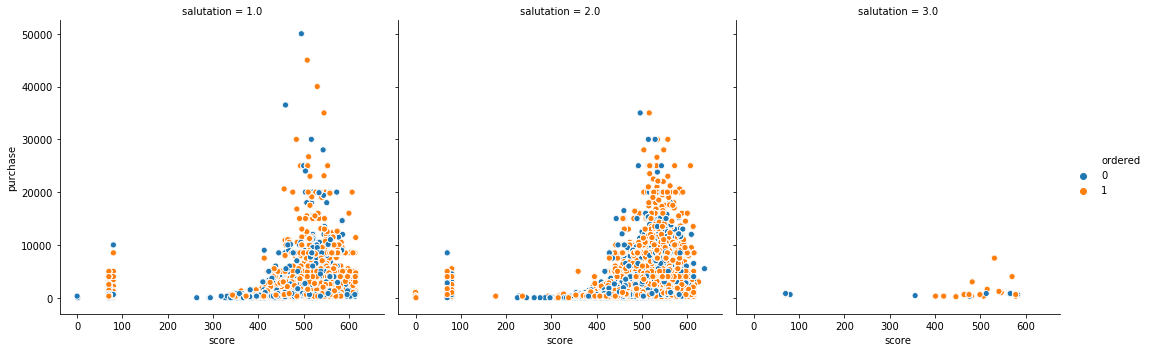

In [201]:
sns.relplot(x="score", y="purchase", col="salutation",
            hue="ordered", #, style="smoker", size="order",
            data=df_train);

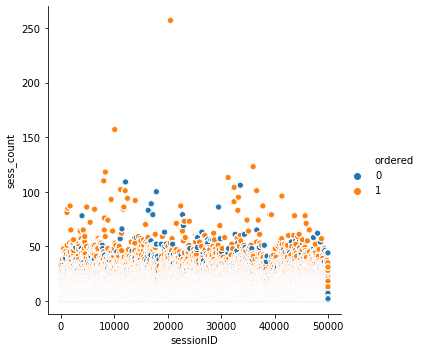

In [195]:
sns.relplot(x="sessionID",y="sess_count",
            hue="ordered", #, style="smoker", size="order",
            data=df_train);

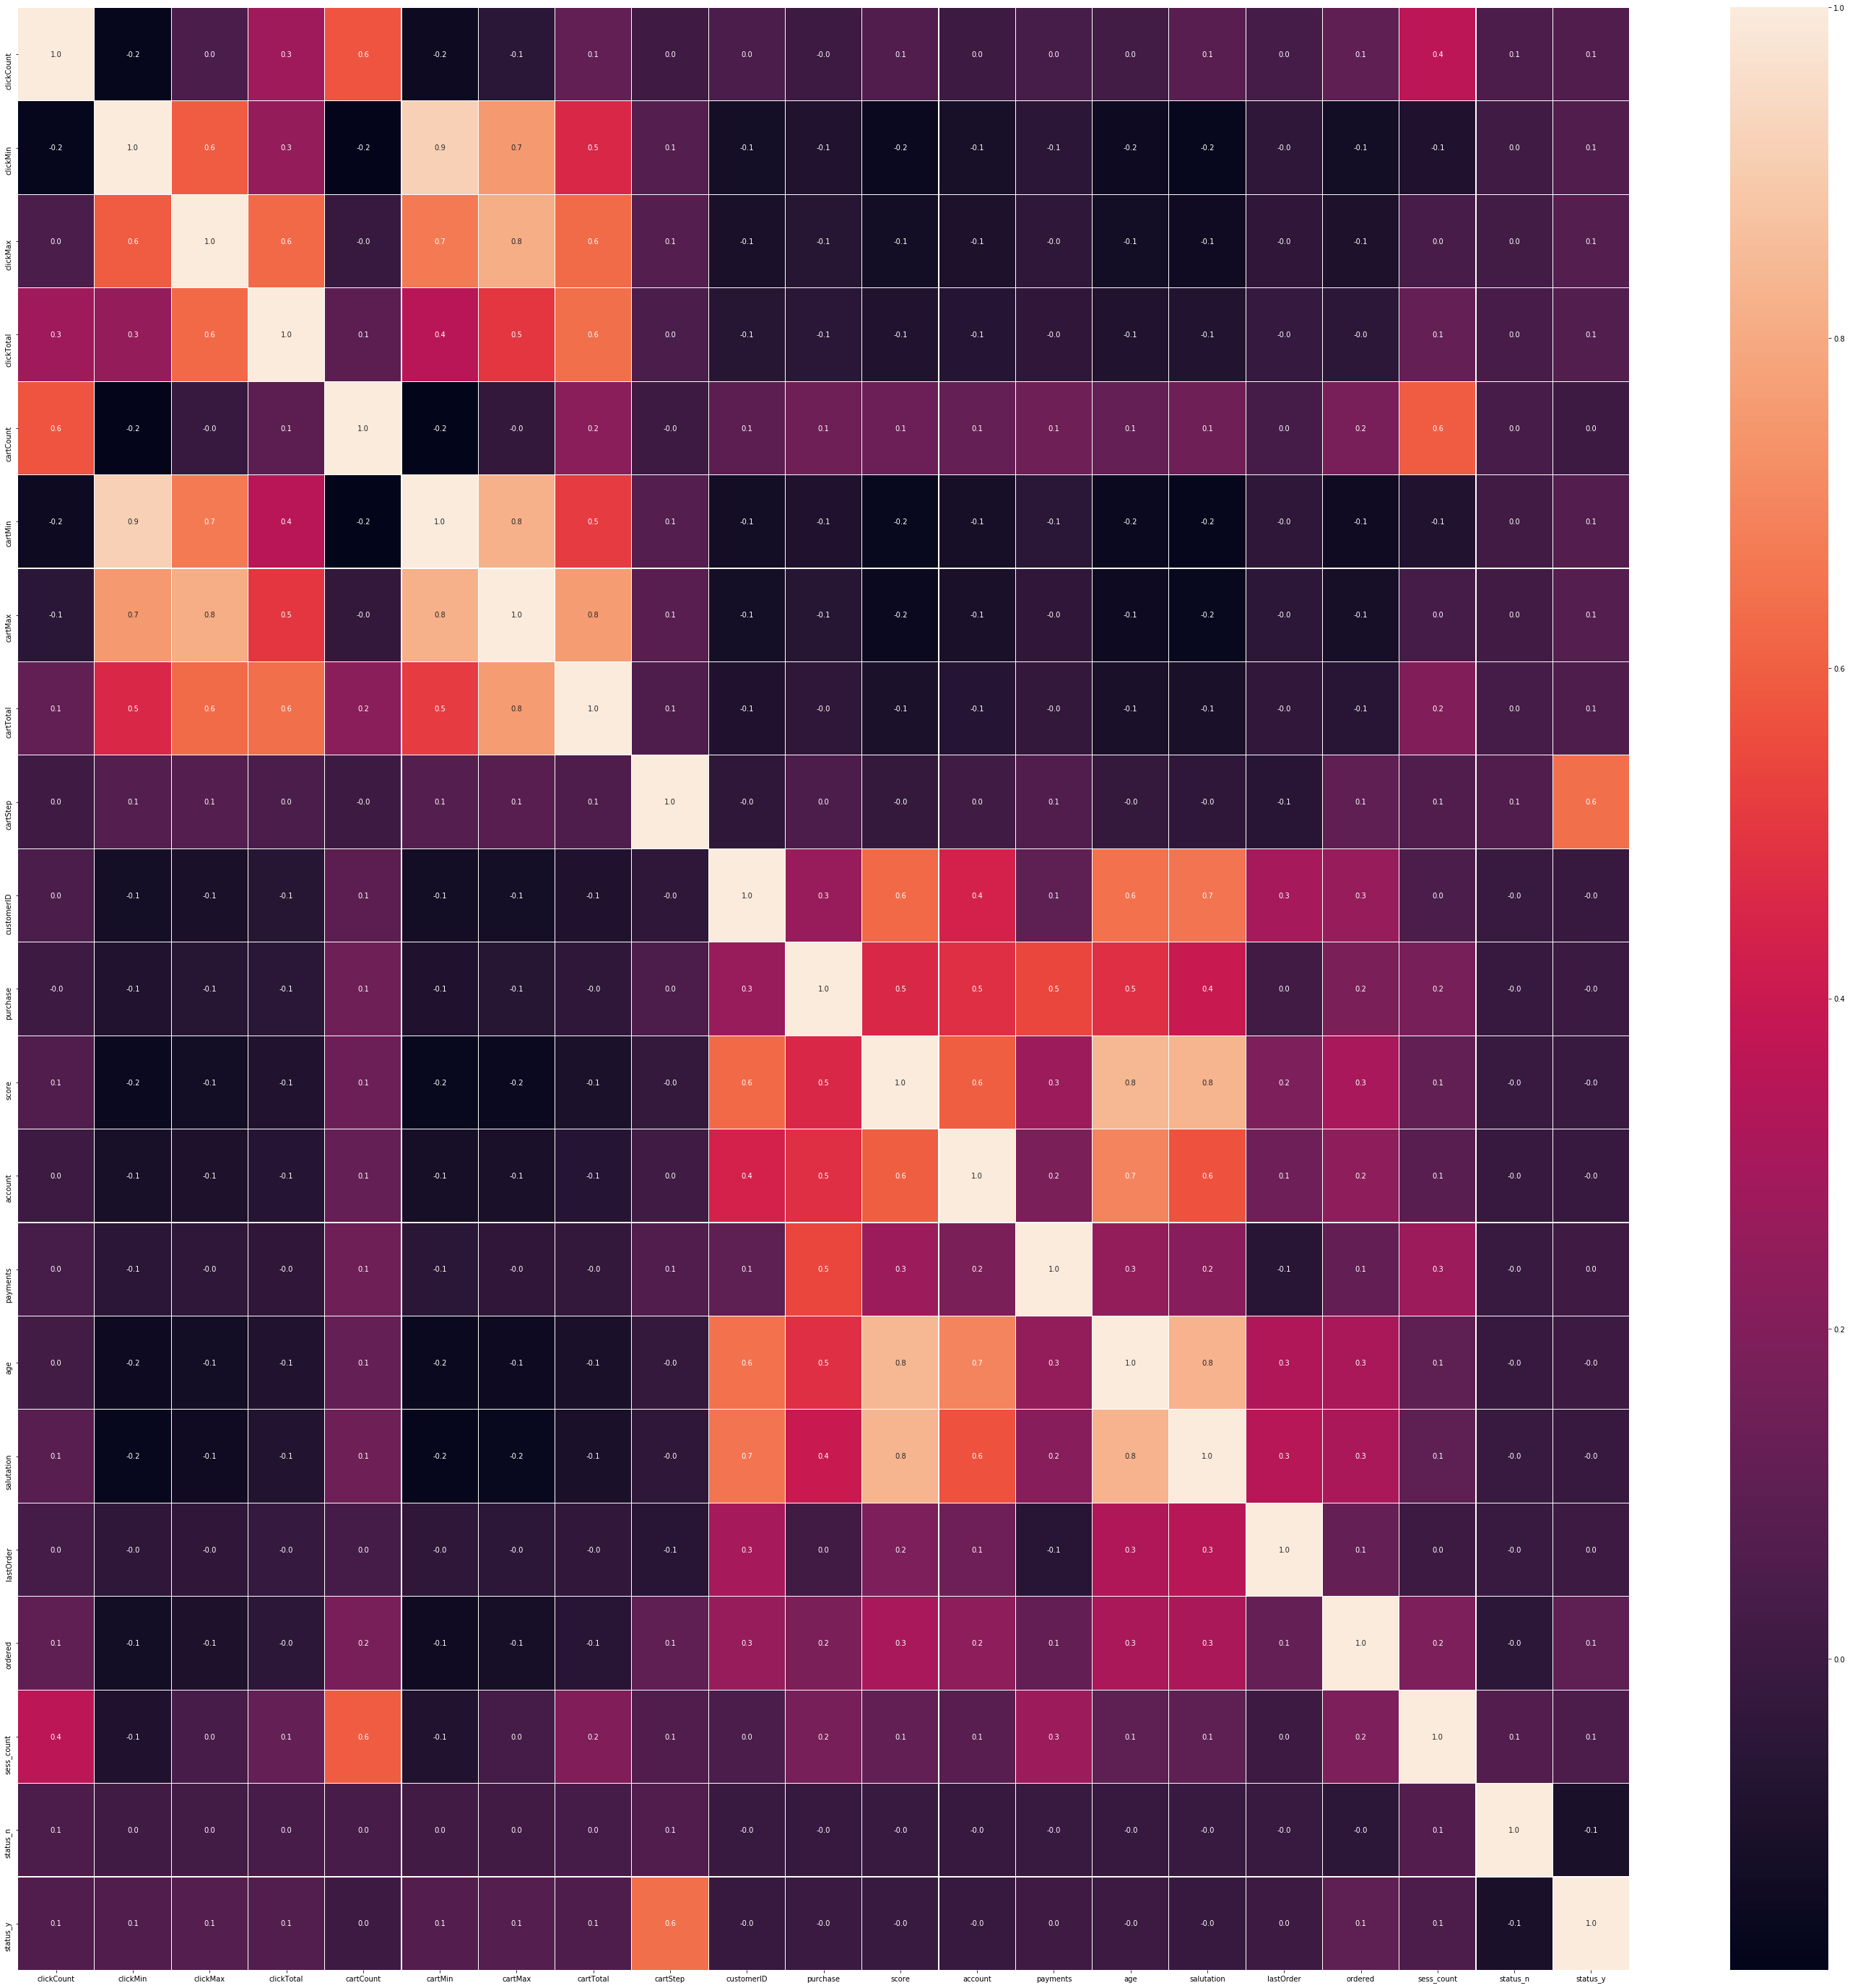

In [202]:
corr = df_train_clensed[df_train_clensed.columns].corr()
plt.figure(figsize = (50,50))
sns.heatmap(corr, annot = True, linewidths=0.1, fmt=".1f");

In [203]:
X, y = df_train_clensed.drop(['ordered'],axis=1), df_train_clensed.ordered
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=68)

In [204]:
#create an array of models as base to see what has highest base score to select for tuning
models = []

models.append(("RF",RandomForestClassifier()))
models.append(("RD Tunned",RandomForestClassifier(max_depth = 35,
                                                  n_estimators= 40,
                                                  random_state=0,
                                                  max_features='auto',
                                                  bootstrap=False,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2)))
models.append(("Dtree",DecisionTreeClassifier()))
models.append(("XGB",xgb.XGBClassifier()))


#measure the accuracy 
for name,model in models:
    kfold = KFold(n_splits=2, random_state=22, shuffle=True)
    cv_result = cross_val_score(model,X_train,y_train, cv = kfold, scoring = "accuracy")
    print(name, cv_result)

RF [0.92769145 0.92833745]
RD Tunned [0.93199279 0.93159455]
Dtree [0.88792889 0.89434917]
XGB [0.84133516 0.83586422]


Source for Parameter running randomforest:
    
https://medium.com/all-things-ai/in-depth-parameter-tuning-for-random-forest-d67bb7e920d

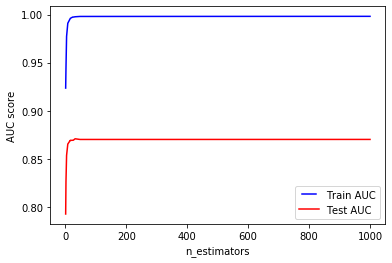

In [46]:
from sklearn.metrics import roc_curve, auc
n_estimators = [1, 2, 4, 8, 16, 16,24,26, 32,48, 1000]
train_results = []
test_results = []
for estimator in n_estimators:
    rf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1)
    rf.fit(X_train, y_train)
    train_pred = rf.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = rf.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, 'b', label="Train AUC")
line2, = plt.plot(n_estimators, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("n_estimators")
plt.show()

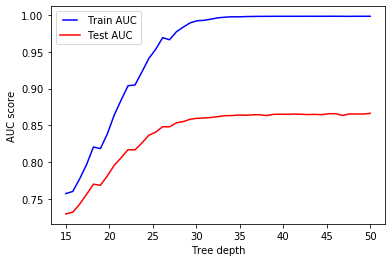

In [90]:
max_depths = np.linspace(15, 50, 45, endpoint=True)
train_results = []
test_results = []

# Loop through each of the max depths and train
for max_depth in max_depths:
    rf = RandomForestClassifier(max_depth=max_depth, n_jobs=-1)
    rf.fit(X_train, y_train)
    train_pred = rf.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = rf.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

line1, = plt.plot(max_depths, train_results,'b', label="Train AUC")
line2, = plt.plot(max_depths, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

In [48]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 50, num = 30)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(20, 40, num = 20)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10,15]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4,6,8]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               40,
               None],
 'max_features': ['auto', 'sqrt', 'log2'],
 'min_samples_leaf': [1, 2, 4, 6, 8],
 'min_samples_split': [2, 5, 10, 15],
 'n_estimators': [20,
                  21,
                  22,
                  23,
                  24,
                  25,
                  26,
                  27,
                  28,
                  29,
                  30,
                  31,
                  32,
                  33,
                  34,
                  35,
                  36,
                  37,
                  38,
                  39,
          

In [49]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rc = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rc_random = RandomizedSearchCV(estimator = rc, param_distributions = random_grid, n_iter = 50, cv = 5, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rc_random.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 15.3min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 27.5min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [50]:
rc_random.best_params_

{'n_estimators': 40,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 35,
 'bootstrap': False}

In [97]:
X_train.describe()

,hour,weekday,duration,clickCount,clickMin,clickMax,clickTotal,cartCount,cartMin,cartMax,cartTotal,cartStep,customerID,purchase,score,account,payments,salutation,lastOrder,status_n,status_y,availability_completely not determinable,availability_completely not orderable,availability_completely orderable,availability_mainly not determinable,availability_mainly not orderable,availability_mainly orderable,availability_mixed
count,112930.000000,112930.000000,112930.000000,112930.000000,112930.000000,112930.000000,112930.000000,112930.000000,112930.000000,112930.000000,112930.000000,112930.000000,112930.000000,112930.000000,112930.000000,112930.000000,112930.000000,112930.000000,112930.000000,112930.000000,112930.000000,112930.000000,112930.000000,112930.000000,112930.000000,112930.000000,112930.000000,112930.000000
mean,14.655999,5.924599,1836.964549,28.260267,42.463619,132.656172,1122.305544,4.867998,52.107635,93.446404,197.755277,2.344612,12034.180917,2630.090321,486.491809,138.707438,17.045727,1.734172,77.882272,0.011919,0.988081,0.004180,0.003852,0.954742,0.000965,0.001435,0.029700,0.005127
std,4.324886,0.787328,2511.548603,32.882123,121.574437,255.372531,2811.350277,4.744858,142.116865,181.662267,357.095308,1.335228,7256.097003,3242.759832,128.661816,110.492754,38.330323,0.443875,113.148706,0.108522,0.108522,0.064515,0.061945,0.207871,0.031053,0.037848,0.169759,0.071420
min,0.000000,5.000000,0.062000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11.000000,5.000000,384.077250,6.000000,5.000000,29.990000,160.940000,2.000000,7.000000,19.990000,47.970000,1.000000,5683.000000,600.000000,481.000000,45.000000,3.000000,1.000000,14.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,15.000000,6.000000,993.482500,16.000000,9.990000,49.990000,432.800000,3.000000,12.990000,39.950000,97.970000,2.000000,11765.000000,1600.000000,520.000000,114.000000,9.000000,2.000000,32.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,18.000000,7.000000,2242.779500,37.000000,19.990000,99.990000,1091.967500,6.000000,29.990000,69.990000,206.795000,4.000000,18083.750000,4000.000000,554.000000,220.000000,16.000000,2.000000,81.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,23.000000,7.000000,21553.323000,200.000000,2199.990000,6999.990000,76239.340000,108.000000,6999.990000,6999.990000,10429.830000,5.000000,25036.000000,50000.000000,638.000000,564.000000,868.000000,3.000000,738.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 36,
 'max_features': 'log2',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 52,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}


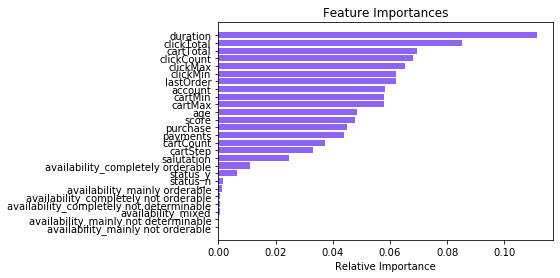

In [113]:
features = X_train.columns.values
importances = clf.feature_importances_
indices = np.argsort(importances)
pprint(clf.get_params())
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='#8f63f4', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show()

In [51]:
rc_random.best_params_

{'n_estimators': 40,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 35,
 'bootstrap': False}

In [ ]:
clf2 = RandomForestClassifier(max_depth = 35, n_estimators= 40, random_state=0, max_features='auto', bootstrap=False,min_samples_leaf=1,min_samples_split=2 )
clf2.fit(X_train, y_train)
print(clf2.feature_importances_)
df_test_cl.describe()

In [ ]:
clf2.score(X_test, y_test)

In [136]:
results = clf2.predict(df_test_cl)

## Get results as csv

1. I create a dataframe with the sessionsID from the test dataset and join it to the results to get a dataframe `"sessionId","order"`. Then we have to  flatten the sessionIds are we get duplicates. 
1. I  sort by order , 1s would be first for a given session ID and then drop all the duplicates
1. I then convert the 1 to y and 0 to n for oder
1. last step is writing out to a csv file

In [137]:
df_results = pd.DataFrame({"sessionID":df_test.sessionID, "order_int":results})
df_results.sort_values(by=['order_int'], ascending=False)
df_dist  = df_results.drop_duplicates(subset = "sessionID", )
df_results.head()

,sessionID,order_int
0,50001,1
1,50001,1
2,50001,1
3,50001,1
4,50001,1


In [138]:
df_dist.loc[df_dist['order_int']==1,'order'] = 'y'
df_dist['order'].fillna('n', inplace=True)
df_final = df_dist.drop('order_int',axis=1)
df_final.head()

/Users/jhiciano/.pyenv/versions/3.6.7/envs/cs-test/lib/python3.6/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/jhiciano/.pyenv/versions/3.6.7/envs/cs-test/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/jhiciano/.pyenv/versions/3.6.7/envs/cs-test/lib/python3.6/site-packages/pandas/core/generic.py:6287: SettingWithCopyWarning: 
A value is tr

,sessionID,order
0,50001,y
9,50002,n
20,50003,y
43,50004,n
49,50005,y


In [139]:
df_final.to_csv("../data/results.csv", index=False)

Automatically created module for IPython interactive environment


/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few tre

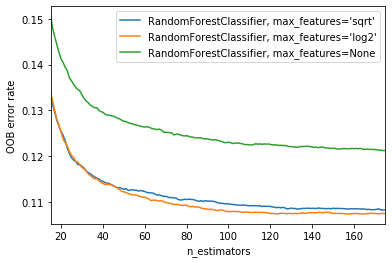

In [100]:
import matplotlib.pyplot as plt

from collections import OrderedDict
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier

# Author: Kian Ho <hui.kian.ho@gmail.com>
#         Gilles Louppe <g.louppe@gmail.com>
#         Andreas Mueller <amueller@ais.uni-bonn.de>
#
# License: BSD 3 Clause

print(__doc__)

RANDOM_STATE = 123

# NOTE: Setting the `warm_start` construction parameter to `True` disables
# support for parallelized ensembles but is necessary for tracking the OOB
# error trajectory during training.
ensemble_clfs = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(warm_start=True, oob_score=True,
                               max_features="sqrt",
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(warm_start=True, max_features='log2',
                               oob_score=True,
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(warm_start=True, max_features=None,
                               oob_score=True,
                               random_state=RANDOM_STATE))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 30
max_estimators = 175

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(X_train, y_train)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()